# JSC Assignment 3: Natural Language Processing

Kaiwen Chen 1004159509

## Introduction

In this assignment, we are starting an investigation into fraud and electricity price manipulation at Enron using the Eron email dataset.

Given those emails, we wish to find out the evidence for potential fraud, discover whom to investigate further, and even prevent further fraud.

However, finding potential frauds is a complicated process as people will hide the sensitive information in their emails. During our investigation, we might not find any explicit evidence for fraud, which makes it extremely difficult to measure the success of our model. Moreover, in a real-world application, because we don't know whether there is a fraud happen in the company forehead and having a fraud is actually a rare event, we would find way less useful evidence directly from our model.

Even though measuring success directly (finding evidence in the data) is almost infeasible for the model, we could evaluate the model implicitly. For example, we can use our model to learn where to start the investigation and compare it with the explicit admissions of guilt. Also, as there are other sources for detecting fraud, if our model is indeed working well, we might expect to observe a decrease in the number of fraud detected by other sources.


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')
import string
import networkx as nx

!pip install gensim
import gensim
from gensim import corpora, models

from collections import Counter
import gensim,logging, warnings
warnings.filterwarnings("ignore")
!pip install pyLDAvis
from pyLDAvis import gensim
from gensim.models import ldamodel
from gensim.models import LdaSeqModel
import pyLDAvis
import pyLDAvis.sklearn
from pyLDAvis import sklearn as sklearn_lda

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 1.7MB 24.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=e0bd9beff57c4b1eb5d37d1dca40fe6faeef4298d19c7d17e4d5dd4e37e359fb
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
!wget https://raw.githubusercontent.com/JSC370/jsc370.github.io/master/enron_top_exe_mails.csv

--2021-03-10 08:50:28--  https://raw.githubusercontent.com/JSC370/jsc370.github.io/master/enron_top_exe_mails.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7935976 (7.6M) [text/plain]
Saving to: ‘enron_top_exe_mails.csv’

enron_top_exe_mails 100%[===================>]   7.57M  --.-KB/s    in 0.08s   

2021-03-10 08:50:28 (99.4 MB/s) - ‘enron_top_exe_mails.csv’ saved [7935976/7935976]



## The data

The entire Enron email dataset contains emails from about 150 users, mostly senior management of Enron. The entire corpus contains a total of about 0.5M messages.

In the scope of this assignment, we are only working on a fraction of this dataset, which consists of 1976 emails from 1999/07 to 2002/01

In [3]:
enron = pd.read_csv("enron_top_exe_mails.csv")
df = pd.DataFrame(enron)

In [4]:
df.head()

,Unnamed: 0,file,message,text,date,senders,recipients,subject
0,0,beck-s/all_documents/330.,Message-ID: <6734979.1075849819614.JavaMail.ev...,"['', 'Arthur Andersen in conjunction with Hype...",2001-01-31 05:35:00-08:00,From: robert.a.seekely@us.arthurandersen.com,To: laura.g.ware@us.arthurandersen.com,Performance Management
1,1,beck-s/discussion_threads/295.,Message-ID: <9563779.1075849841009.JavaMail.ev...,"['', 'Arthur Andersen in conjunction with Hype...",2001-01-31 05:35:00-08:00,From: robert.a.seekely@us.arthurandersen.com,To: laura.g.ware@us.arthurandersen.com,Performance Management
2,2,dasovich-j/all_documents/247.,Message-ID: <13169797.1075842938250.JavaMail.e...,"['\tagrubb@calnurses.org, mcgee.nora@epamail.e...",1999-12-06 23:47:00-08:00,From: jeffrey.l.walker@us.arthurandersen.com,To: perin@sirius.com,Re: dinner next tuesday
3,3,dasovich-j/all_documents/249.,Message-ID: <14388889.1075842938392.JavaMail.e...,"['\tagrubb@calnurses.org, mcgee.nora@epamail.e...",1999-12-07 20:44:00-08:00,From: jeffrey.l.walker@us.arthurandersen.com,To: lnewmansciarrino@elanpharma.com,RE: dinner next tuesday
4,4,dasovich-j/all_documents/301.,Message-ID: <21305507.1075842940032.JavaMail.e...,"['X-To: pat.scatena@intel.com', 'X-cc: agrubb@...",2000-01-16 14:48:00-08:00,From: jeffrey.l.walker@us.arthurandersen.com,To: pat.scatena@intel.com,RE: Porlock Vale in 2000


In [5]:
df = df.drop("Unnamed: 0", axis=1)

In [6]:
# text preprocessing 

df["text"] = df['text'].apply(lambda x: x.strip('[]')) 
df["text"] = df['text'].apply(lambda x: x.strip("'',"))
df["text"] = df['text'].apply(lambda x: x.strip(", '',"))

# remove "From" from sender mail ids
def remove_from(text): 
    mail = re.sub(r'From:', '', text)
    return mail

# remove "To" from recipient mail ids
def remove_to(text): 
    mail = re.sub(r'To:', '', text)
    return mail

#remove unnecessary line breakers 
def remove_obj(text): 
    mail = re.sub('\'', '', text)
    return mail

#defin a function to remove punctuation from text
def remove_punct(text):
    punct = "".join([i for i in text if i not in string.punctuation])
    return punct

# remove numbers from mail body 
def remove_numbers(text): 
    mail = re.sub(r"\d+", "", text)
    return mail



# applying all defined functions 
df['senders'] = df['senders'].apply(lambda x : remove_from(x))

df['recipients'] = df['recipients'].apply(lambda x : remove_to(x))

df['text'] = df['text'].apply(lambda x : remove_obj(x))

df['text'] = df['text'].apply(lambda x : remove_punct(x)) 

df['text'] = df['text'].apply(lambda x : remove_numbers(x))


In [7]:
# defining top_k_words from mail body 
def get_stop_words():
    stop = set(stopwords.words('english'))
    
    stop.add("enron")
    stop.add("XFrom")
    stop.add("XTo")
    stop.add("Xcc")
    stop.add("Xbcc")
    stop.add("XFolder")
    
    return stop

def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    mails = df['text'].values

    for mail in mails:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', mail)
                            if word.lower() not in stop and len(word) > 2 ])
    topk = counter.most_common(kwords)
    return topk


In [8]:
df["recipients_flatten"] = df["recipients"].apply(lambda x: x.strip().split(","))
df["senders"] = df["senders"].apply(lambda x: x.strip())

The graph below demonstrates the number of emails sends per month. We found an unexpected timestamp in the dataset, which is 1979/12.

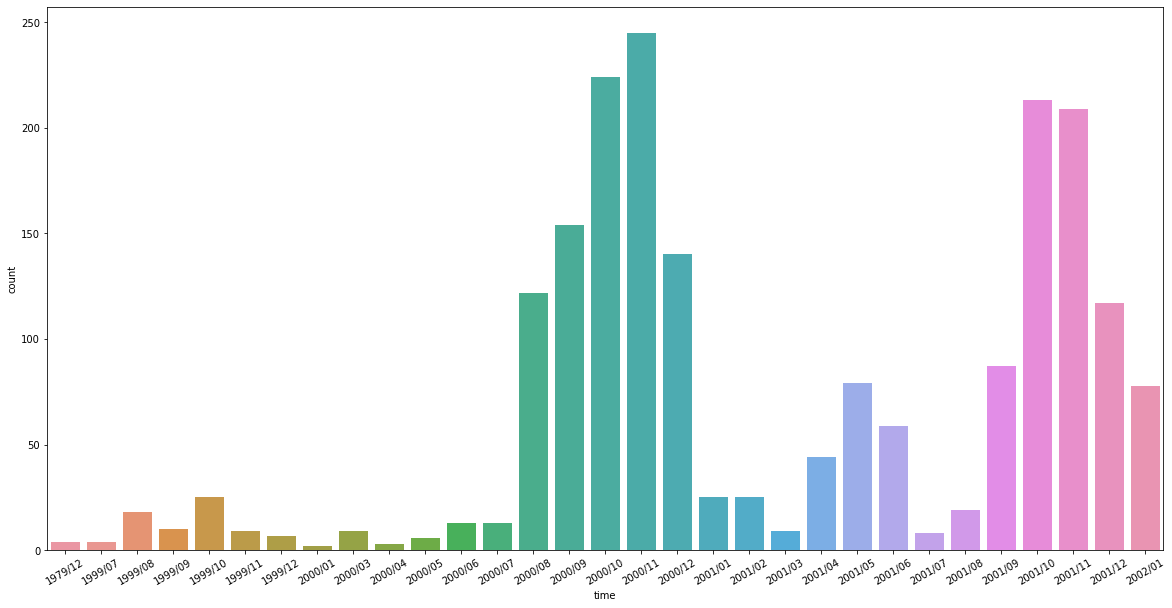

In [9]:
df["date"] = df["date"].apply(pd.to_datetime)
df["year_month"] = df["date"].apply(lambda x:x.strftime('%Y/%m'))
frequency = df["year_month"].value_counts(sort=False).reset_index().sort_values(["index"])
frequency.columns = ['time', 'count']
plt.figure(figsize=(20,10))
g = sns.barplot(x="time", y="count", data=frequency )
g.set_xticklabels(g.get_xticklabels(), rotation=30);

In [10]:
error_date = "1979/12"
df[df["year_month"]==error_date]

,file,message,text,date,senders,recipients,subject,recipients_flatten,year_month
184,kean-s/all_documents/121.,Message-ID: <7230661.1075846142733.JavaMail.ev...,Xbcc XFolder StevenKeanDecNotes FoldersAll do...,1979-12-31 16:00:00-08:00,steven.kean@enron.com,kenneth.lay@enron.com,Further information regarding Gov Thompson,[kenneth.lay@enron.com],1979/12
216,kean-s/archiving/untitled/2205.,Message-ID: <33244591.1075846267388.JavaMail.e...,Xbcc XFolder StevenKeanDecNotes FoldersArchiv...,1979-12-31 16:00:00-08:00,steven.kean@enron.com,kenneth.lay@enron.com,Further information regarding Gov Thompson,[kenneth.lay@enron.com],1979/12
256,kean-s/calendar/untitled/121.,Message-ID: <4764867.1075846273865.JavaMail.ev...,Xbcc XFolder StevenKeanDecNotes FoldersCalend...,1979-12-31 16:00:00-08:00,steven.kean@enron.com,kenneth.lay@enron.com,Further information regarding Gov Thompson,[kenneth.lay@enron.com],1979/12
290,kean-s/discussion_threads/120.,Message-ID: <2828867.1075848072222.JavaMail.ev...,Xbcc XFolder StevenKeanJuneNotes FoldersDiscu...,1979-12-31 16:00:00-08:00,steven.kean@enron.com,kenneth.lay@enron.com,Further information regarding Gov Thompson,[kenneth.lay@enron.com],1979/12


After taking a closer look at those outliers, it seems that those four duplicated emails are mislabeled, and we could remove them from the dataset

In [11]:
df = df[df["year_month"]!=error_date]
df = df.sort_values(by=["year_month"])

Now, we can investigate the number of emails received for each person. The following box plot shows an overview of the distribution. However, there are two outliers that receive much more than others which makes the plot hard to read.

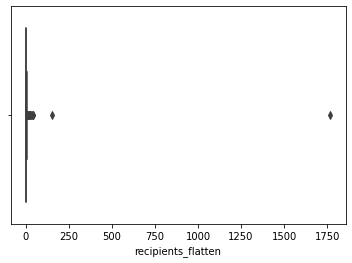

In [12]:
df_flatten = df.explode('recipients_flatten').reset_index(drop=True)
df_flatten["recipients_flatten"] = df_flatten["recipients_flatten"].apply(lambda x: x.strip())
sns.boxplot(x=df_flatten["recipients_flatten"].value_counts())

Here is a numeric description for the top 20 users in terms of the number of emails received. Clearly, there are much more emails sent to kenneth.lay@enron.com and jeff.skilling@enron.com than all other uses.

In [13]:
df_flatten["recipients_flatten"].value_counts()[:20]

kenneth.lay@enron.com                    1768
jeff.skilling@enron.com                   154
rosalee.fleming@enron.com                  44
andrew.fastow@enron.com                    40
greg.whalley@enron.com                     39
kenneth_lay@enron.com                      33
mrslinda@lplpi.com                         24
mark.frevert@enron.com                     24
joseph.sutton@enron.com                    23
steven.kean@enron.com                      19
allan.roberts@uk.arthurandersen.com        13
michael.abraham@us.arthurandersen.com      12
jlaywp@aol.com                             12
paul.e.day@uk.arthurandersen.com           12
cindy.olson@enron.com                      11
j..kean@enron.com                          10
richard.shapiro@enron.com                   9
vince.j.kaminski@enron.com                  9
skean@enron.com                             8
louise.kitchen@enron.com                    8
Name: recipients_flatten, dtype: int64

After removing those two outliers, the boxplot becomes much more readable and it shows that most of the users only receive a small number of emails (<10), while a few users contribution a lot to the number of emails received.

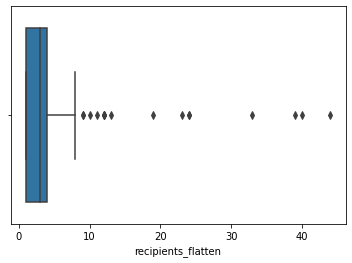

In [14]:
sns.boxplot(x=df_flatten["recipients_flatten"].value_counts()[2:])

We can do the same analysis to the number of emails sent for each person. In fact, we observe a similar trend as the number of emails received.

In [15]:
df["senders"].value_counts()[:20]

steven.kean@enron.com                100
vince.kaminski@enron.com              42
david.delainey@enron.com              32
karen.denne@enron.com                 31
rob.bradley@enron.com                 30
elizabeth.lay@enron.com               27
terrie.james@enron.com                26
cindy.stark@enron.com                 24
j..kean@enron.com                     22
kenneth.lay@enron.com                 21
svarga@kudlow.com                     20
maureen.mcvicker@enron.com            20
jeffrey.garten@yale.edu               20
mrslinda@lplpi.com                    19
mark.lay@enron.com                    18
joe.hillings@enron.com                17
greg.piper@enron.com                  14
enron_update@concureworkplace.com     13
michael.mann@enron.com                13
lizard_ar@yahoo.com                   12
Name: senders, dtype: int64

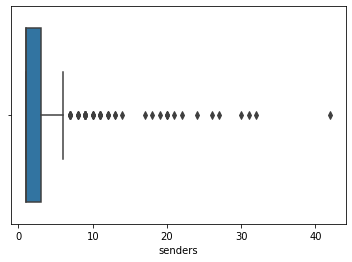

In [16]:
sns.boxplot(x=df["senders"].value_counts()[1:])

## List of factors that could affect the recorded data

Various factors could affect the recorded email. For example, the position change in the company, writing the email in a different language, writing an email with encoded symbol/word, suspicion of fraud and the account is being hacked.

## Model Staircase

1. Simple keyword searches to filter suspicion emails
2. Do a simple network analysis to see who wrote to whom and explore the scocial network relation in the company.
3. Run a topic model on the whole corpus, then see how the topic use varies with time. If we can find an anomaly use, then it is probably a hint for fraud.2. Run a topic model on the whole corpus, then see how the topic use varies with time. If we can find an anomaly use, then it is probably a hint for fraud.
4. Run a dynamic topic model and see how the top words in each topic changed.

For this assignment, I will implement the model 2-4.

Since there is no ground truth or a feasible metric to evaluate each model, we will measure the success of the model by doing a visual analysis of the topics and the network.


### Network Analysis

As discussed earlier, most of the users only contribute a small number of emails to the dataset, which makes it hard to analyze their social network. Based on this observation, I decided to only analyze those active users that are either sent a lot of emails or received a lot of emails.

In [17]:
threshold = 15
recipients_threshold = df_flatten["recipients_flatten"].value_counts()>threshold
df_threshold = df_flatten[recipients_threshold[df_flatten["recipients_flatten"]].reset_index(drop=True)].reset_index(drop=True)
sender_threshold = df["senders"].value_counts()>threshold
df_threshold = df_threshold[sender_threshold[df_threshold["senders"]].reset_index(drop=True)]
df_threshold = df_threshold.reset_index(drop=True)

In total, there are only 23 users that are sent or received more than 15 emails.

In [18]:
all_people = np.concatenate([df_threshold["recipients_flatten"].unique(),df_threshold["senders"].unique()])
all_people = np.unique(all_people)
len(all_people)

23

Here is the graph for the social network. The directed arrow from A to B indicates that A has sent at least one email to B.

We can see the connection between people. For example, it seems that Kenneth lay received an email from almost everyone.

One thing that is pretty strange about this network is that the arrow is not bidirectional, which indicates that those who received a lot of emails are not sending much. It is pretty weird as we might expect those people are active users and they should both sent and received emails frequently.

However, it seems that only 'mrslinda@lplpi.com' are both the frequent sender and the frequent receiver. There are several explanations for it, for example, it could because people are not used to communicating by email at that time, or it could because of the bias in selecting the small sample dataset. Moreover, it could indicate a sign of a massive deletion in the mailbox, which we might need to further investigate for potential fraud.

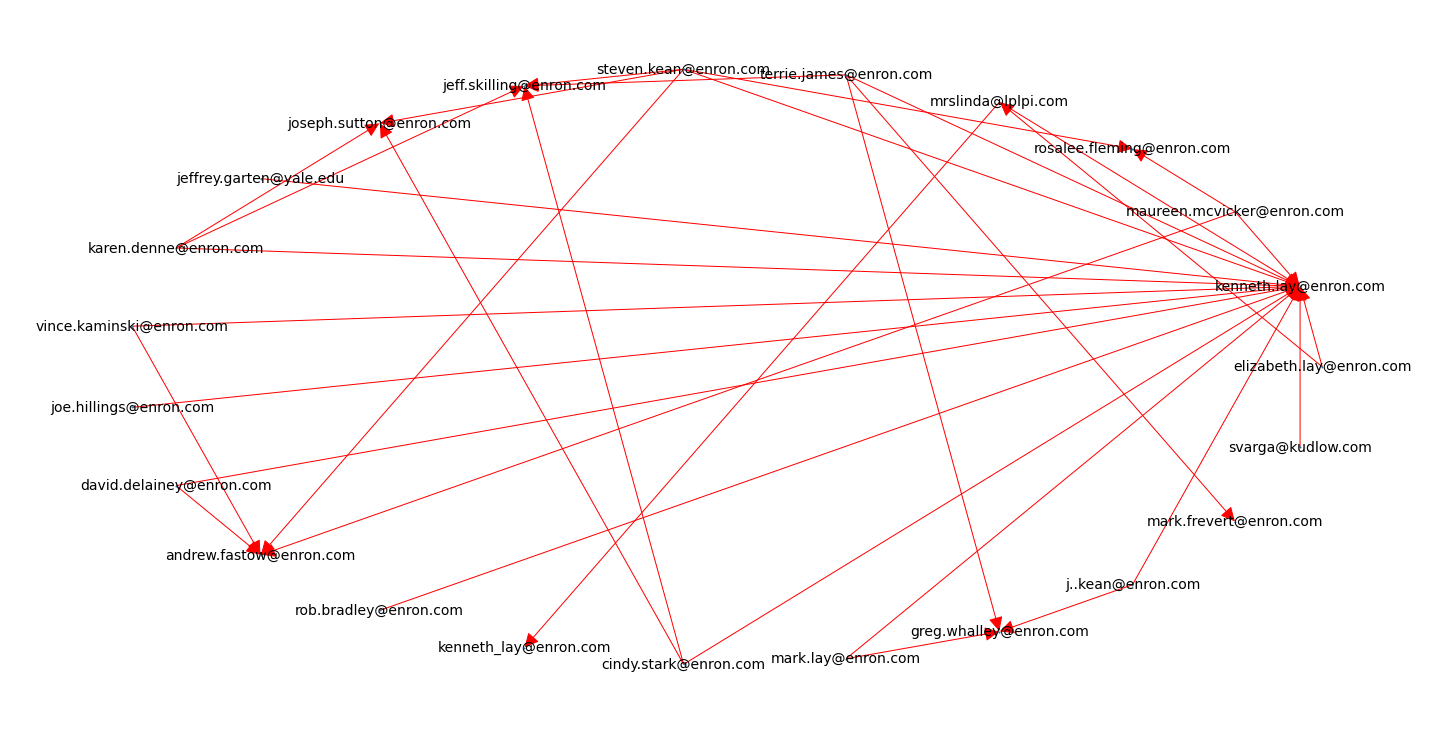

In [19]:
plt.figure(figsize=(20,10))
G = nx.from_pandas_edgelist(df_threshold, "senders", "recipients_flatten",create_using=nx.DiGraph)
nx.draw_circular(G, font_size=14, with_labels=True,arrowsize=30,node_size=1, edge_color="r")

In [20]:
set(df_threshold["senders"].unique()).intersection(df_threshold["recipients_flatten"].unique())

{'mrslinda@lplpi.com'}

### Latent Dirichlet Allocation topic model

We can use the LDA model to investigate the topic of the entire corpus within the top 50 words.

In [21]:
# finding top 50 words used in the mails received by kenneth 
cf_df = df
top_words = getTopKWords(cf_df, 50)

In [22]:
# creating dictionary of relevant words
# we are using top 50 words from the mails received by co-founder
corp = []
for i, j in top_words:
    corp.append(i)
corp = [word.split() for word  in corp]   # converting individual token (useful for creating gensim dicionary)

In [23]:
# creating corpora of the relevant keywords
id2word = corpora.Dictionary(corp)

In [24]:
# tokenizing mail body text so that is useful for topic modeling 
# use regular expression tokenizer to tokenize
tokenizer = RegexpTokenizer(r'\w+')
cf_df['text'] = cf_df['text'].apply(lambda x : tokenizer.tokenize(x))
cf_df = cf_df.sort_values(by=["year_month"])
all_month = cf_df["year_month"].value_counts().reset_index().sort_values(by=["index"])["year_month"].to_numpy()

In [25]:
stop = get_stop_words()
clean_mails = cf_df['text'] 
clean_mails = clean_mails.apply(lambda words: [word.lower() for word in words if word.lower() not in stop])

In [26]:
# creating corpus with term document frequency of the abstracts
corpus = [id2word.doc2bow(text) for text in clean_mails]

In [27]:
# finding tf_idf scores with corpus
tfidf = models.TfidfModel(corpus)
tf_corpus = tfidf[corpus]

In [28]:
# calling LDA model
# we are modeling for 5 topics
LDA_gen = ldamodel.LdaModel(corpus=tf_corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=3,
                                           passes=3,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True);

In [29]:
print(LDA_gen.print_topics(num_words=5)) # printing top keywords in top 5 topics

[(0, '0.346*"people" + 0.324*"like" + 0.236*"thanks" + 0.060*"would" + 0.001*"good"'), (1, '0.079*"company" + 0.076*"new" + 0.069*"lay" + 0.064*"time" + 0.063*"last"'), (2, '0.236*"houston" + 0.222*"business" + 0.147*"layk" + 0.147*"xfilename" + 0.118*"xorigin"'), (3, '0.115*"may" + 0.106*"please" + 0.096*"message" + 0.093*"know" + 0.079*"need"'), (4, '0.339*"best" + 0.324*"call" + 0.163*"make" + 0.145*"next" + 0.001*"may"')]


After fitting the LDA model on the entire corpus, we wish to find out how the topic use varies with time. To do so, we need to extract the predicted probability for each document, group them by the month and calculate the marginal probability for each topic of each month.

The final probability table is presented by the heat map. The darker the block for a particular topic and time, the more frequently that the topic occurs in the documents of the particular month.

In [30]:
all_prob = (np.array(LDA_gen.get_document_topics(tf_corpus))[:,:,1])

month_index = cf_df["year_month"].value_counts().reset_index().sort_values(by=["index"]).reset_index(drop=True)
month_index.columns = ["year_month","count"]
# all_prob = log(softmax(all_gama,axis=1)

In [31]:
# prob_with_time = pd.DataFrame(all_prob)
prob_with_time = pd.concat([pd.DataFrame(all_prob), cf_df["year_month"]], axis=1)
# prob_with_time= pd.merge(prob_with_time, month_index, on="year_month")
prob_with_time = pd.merge(prob_with_time.groupby("year_month").sum(),month_index, on="year_month")
prob_with_time  = prob_with_time.set_index("year_month")
prob_with_time  = prob_with_time.apply(lambda x: (x[:5]/x["count"]), axis=1)
prob_with_time.columns = range(1,6)

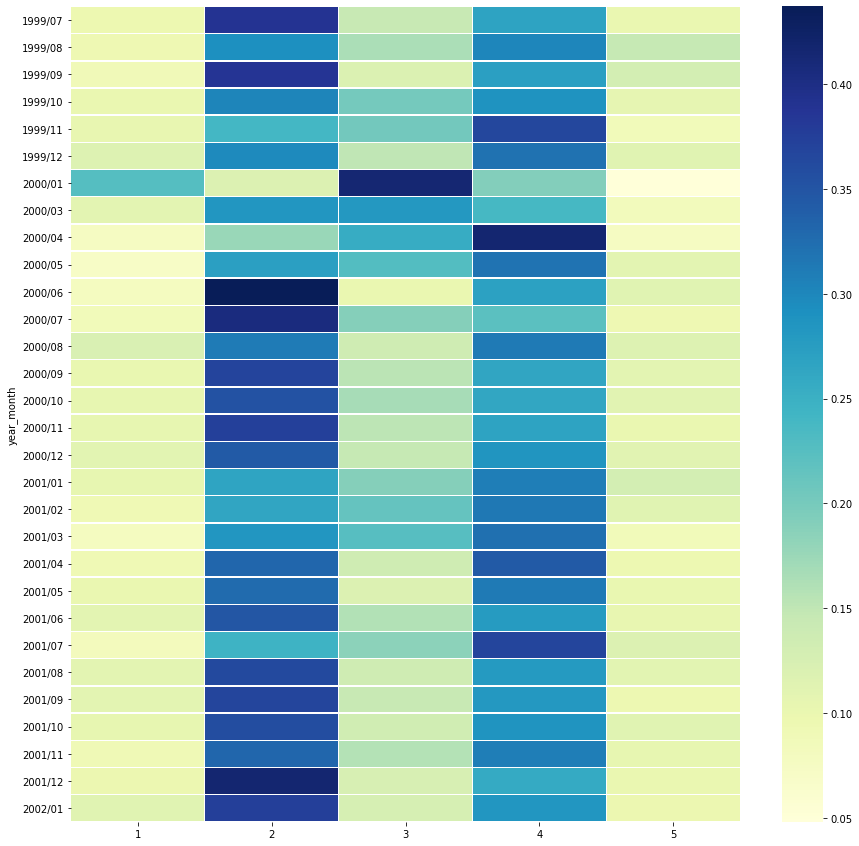

In [32]:
plt.figure(figsize=(15,15))
sns.heatmap(prob_with_time,linewidths=.5,cmap="YlGnBu");

Below are the top words used in each of the topics.

By examining the heat map, we observe that the second topic and fourth topic are commonly used throughout the time. 

The second topic contains the word "company", "employees" and also the "lay", the co-founder of Eron, which is related to the daily routine of a company. The fourth topic is mainly about sending messages and email. Thus, it kinds of make sense why those two topics appear predominantly.

Moreover, we can see the usage of the third topic is fluctuating but decreasing with time and this topic might be related to scheduling a business meeting in Houston, where the company is based. I believe the reason why the usage of this topic is decreasing should be related to the fact that Enron filed for bankruptcy in late 2001.

In [33]:
LDA_gen.print_topic(0)

'0.346*"people" + 0.324*"like" + 0.236*"thanks" + 0.060*"would" + 0.001*"good" + 0.001*"see" + 0.001*"could" + 0.001*"business" + 0.001*"get" + 0.001*"know"'

In [34]:
LDA_gen.print_topic(1)

'0.079*"company" + 0.076*"new" + 0.069*"lay" + 0.064*"time" + 0.063*"last" + 0.059*"employees" + 0.049*"year" + 0.049*"one" + 0.047*"could" + 0.044*"many"'

In [35]:
LDA_gen.print_topic(2)

'0.236*"houston" + 0.222*"business" + 0.147*"layk" + 0.147*"xfilename" + 0.118*"xorigin" + 0.070*"meeting" + 0.025*"please" + 0.007*"know" + 0.001*"attached" + 0.001*"new"'

In [36]:
LDA_gen.print_topic(3)

'0.115*"may" + 0.106*"please" + 0.096*"message" + 0.093*"know" + 0.079*"need" + 0.070*"get" + 0.065*"sent" + 0.064*"email" + 0.055*"help" + 0.043*"let"'

In [37]:
LDA_gen.print_topic(4)

'0.339*"best" + 0.324*"call" + 0.163*"make" + 0.145*"next" + 0.001*"may" + 0.001*"would" + 0.001*"see" + 0.001*"business" + 0.001*"email" + 0.001*"could"'

We can also visualize the topic using the pyLDAvis library. It shows that the first topic and the fifth topic are closely related. Also, it shows that there is some relation between the second and third topics, while the fourth topic is standalone.

In [59]:
# Topics visualization using pyLDAvis
pyLDAvis.enable_notebook()
# topic visualization
titles = pyLDAvis.gensim.prepare(LDA_gen, tf_corpus, dictionary=LDA_gen.id2word)
titles

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.170003  0.164467       1        1  36.270062
3     -0.254643  0.068705       2        1  28.545618
2     -0.269908  0.009499       3        1  14.824804
4      0.115409 -0.405168       4        1  10.454924
0      0.239138  0.162497       5        1   9.904593, topic_info=       Term        Freq       Total Category  logprob  loglift
26     best  194.000000  194.000000  Default  30.0000  30.0000
35   people  187.000000  187.000000  Default  29.0000  29.0000
22     call  185.000000  185.000000  Default  28.0000  28.0000
12     like  175.000000  175.000000  Default  27.0000  27.0000
18  houston  191.000000  191.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
27    thank    0.392196  143.986595   Topic5  -7.2251  -3.5935
5      time    0.391676  127.822258   Topic5  -7.2265  -3.4758
11      new    0.391574  150.483137   Topic5  -7.2267  -3.6393
2    please    0.390857  185.520944   Topic5  -7.2286  -3.8504
4   message    0.390802  150.046058   Topic5  -7.2287  -3.6383

[229 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
20        1  0.973984      also
20        3  0.023756      also
45        2  0.963414  attached
45        3  0.026038  attached
26        3  0.005150      best
...     ...       ...       ...
21        3  0.987954   xorigin
46        1  0.984766      year
46        3  0.010152      year
32        1  0.977883     years
32        3  0.012537     years

[98 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 5, 1])

## Sequential LDA - dynamic topic model

Dynamic topic models are used to analyze the evolution of topics for a collection of documents over time. 

In the content of this assignment, we will use the sequential LDA model to analyze the change of the top words in each topic.

In [38]:
model_path = "ldaseq_model"

# ldaseq = LdaSeqModel(corpus=tf_corpus,time_slice=all_month,
#                                           id2word=id2word,
#                                           num_topics=5,
#                                           random_state=100
#                                           ); 
# ldaseq.save(model_path)


# As training will take a lot of time
# we can load the saved model when restart the colab run time
ldaseq = LdaSeqModel.load(model_path)

In [39]:
# A list of top 6 words that we are interested
all_top_word = []
for t in range(5):
  all_top_word.append(ldaseq.print_topic_times(t, top_terms=6))
all_top_word = np.array(all_top_word)

In [40]:
# A list of all words and corresponding probabilities that are produced by the model
all_word = []
for t in range(5):
  all_word.append(ldaseq.print_topic_times(t))
all_word = np.array(all_word)

In [47]:
all_unique_word_prob = []
time_length = len(month_index)
for t in range(5):
  all_top_word_topic= np.unique(all_top_word[t,:,:,0])
  top_word_prob = np.zeros((time_length,len(all_top_word_topic)))
  for i in range(time_length):
    for word in all_word[t,i,:,]:
      if(word[0] in all_top_word_topic):
        top_word_prob[i,np.where(all_top_word_topic == word[0])] = word[1]
  prob_df = pd.DataFrame(top_word_prob).set_index(month_index["year_month"])
  prob_df.columns = all_top_word_topic
  all_unique_word_prob.append(prob_df)

After fitting the model, I draw the heatmap for the probability of each top word in each topic over time.

The darker the block for a time t and word w, the higher the frequency that the word w is used in this topic at time t.

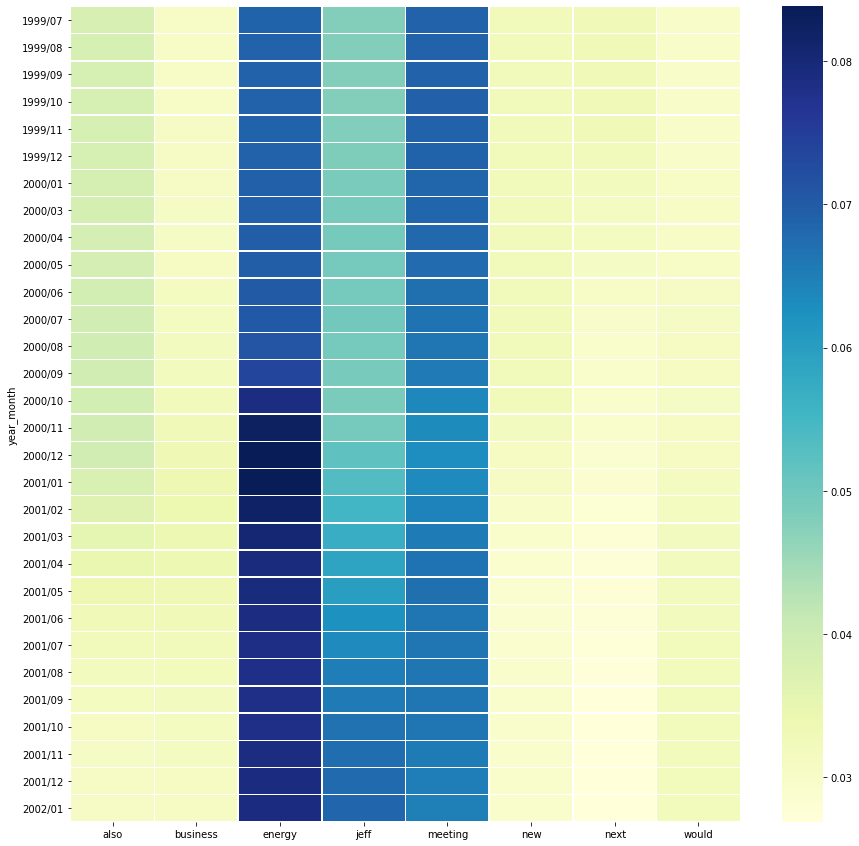

In [51]:
plt.figure(figsize=(15,15))
sns.heatmap(all_unique_word_prob[0],linewidths=.5,cmap="YlGnBu");

Above is the heatmap for the first topic, while the usage for most of the words remains constant over time, we can sort of seeing that the words "energy" and "jeff" are increasing in usage with time.

The words "jeff" probably indicate Jeffrey Skilling, who is the CEO of Enron. The word "energy" should relate to the fact that Enron is an energy-trading and utility company.

However, it is hard to figure out the reason behind this phenomenon by just looking at this graph as many other factors might contribute to it. For example, it is possible that Jeffrey Skilling was proposing more new energy trade over time.

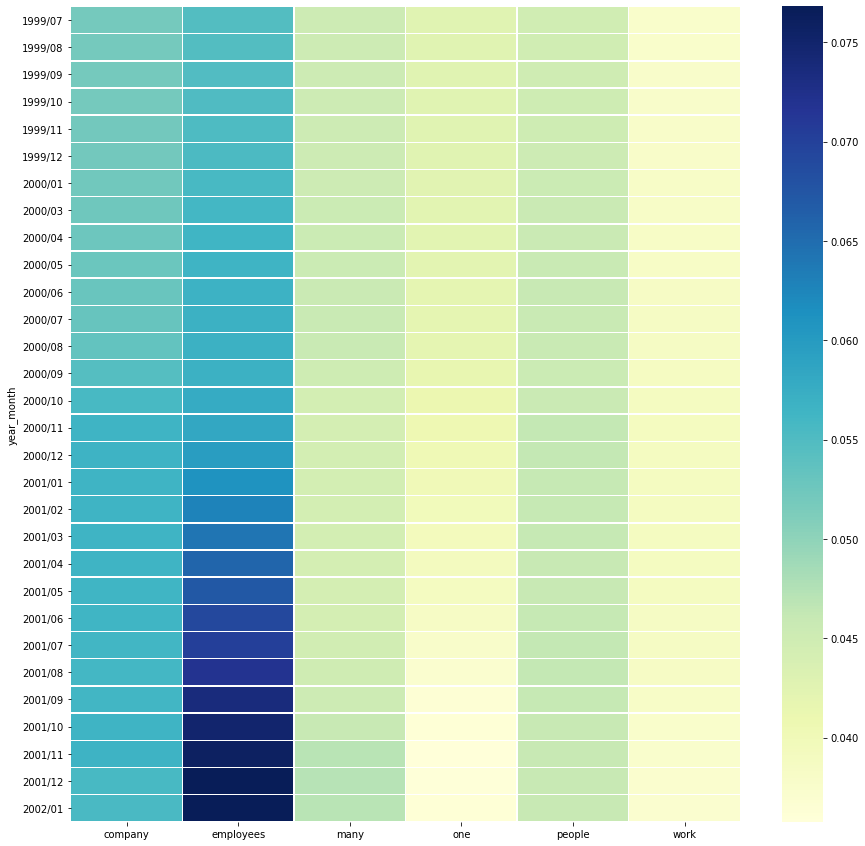

In [55]:
plt.figure(figsize=(15,15))
sns.heatmap(all_unique_word_prob[1],linewidths=.5,cmap="YlGnBu");

Here is the heatmap for the second topic, we observed a significant increase in the usage of the word "employees".

I think this particular topic is related to the people that are working in Enrons and as the word "employees" appears much more often around 2001, I suspect that there could be some dynamic change in terms of handling the employees of the company.

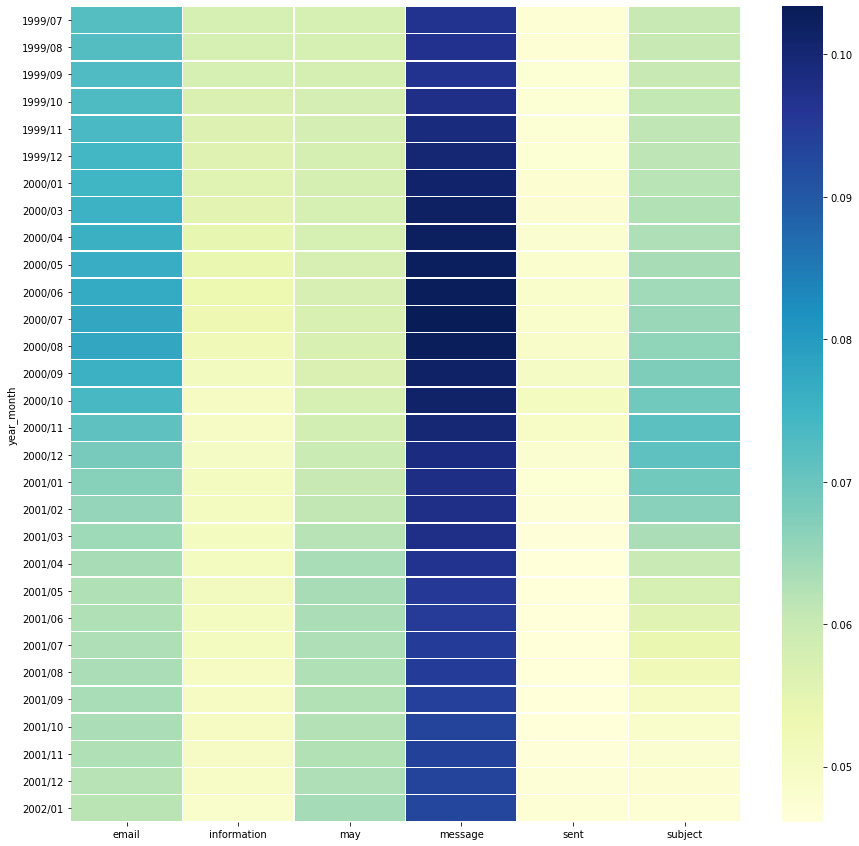

In [56]:
plt.figure(figsize=(15,15))
sns.heatmap(all_unique_word_prob[2],linewidths=.5,cmap="YlGnBu");

The third topic should be related to sending messages and the salient word in this topic doesn't change much. However, we do observe a slowly decreasing trend in the use of the word "email". It might be an indication that people in Enron are more likely to communicate with tools other than email.

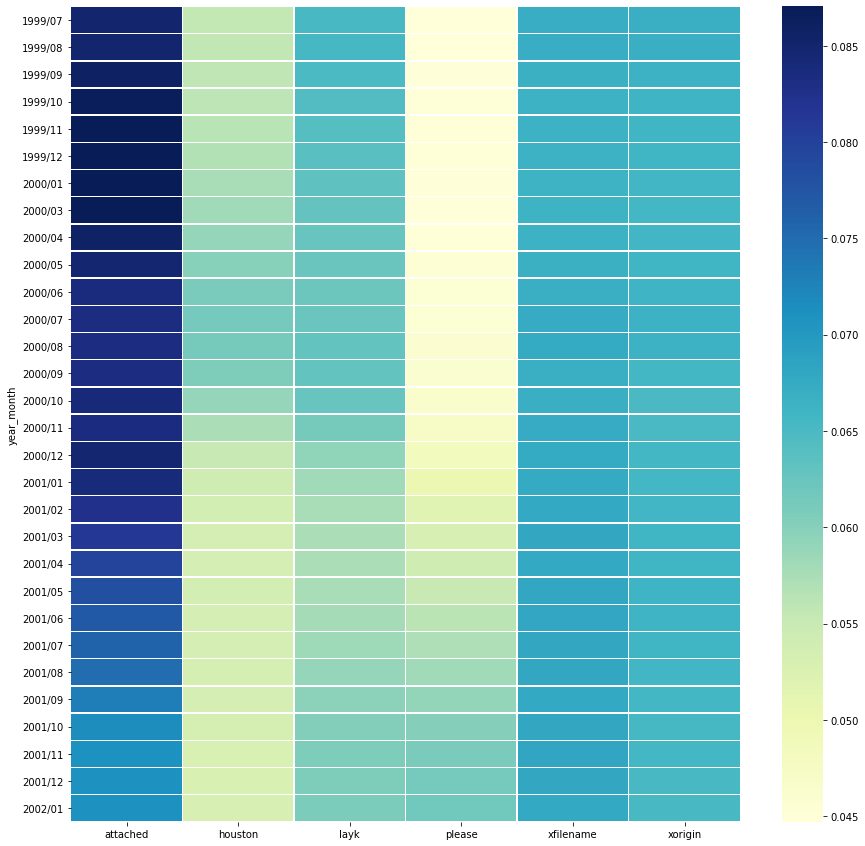

In [57]:
plt.figure(figsize=(15,15))
sns.heatmap(all_unique_word_prob[3],linewidths=.5,cmap="YlGnBu");

The fourth topic seems to be common words used in emails and it doesn't show a significant change over time.

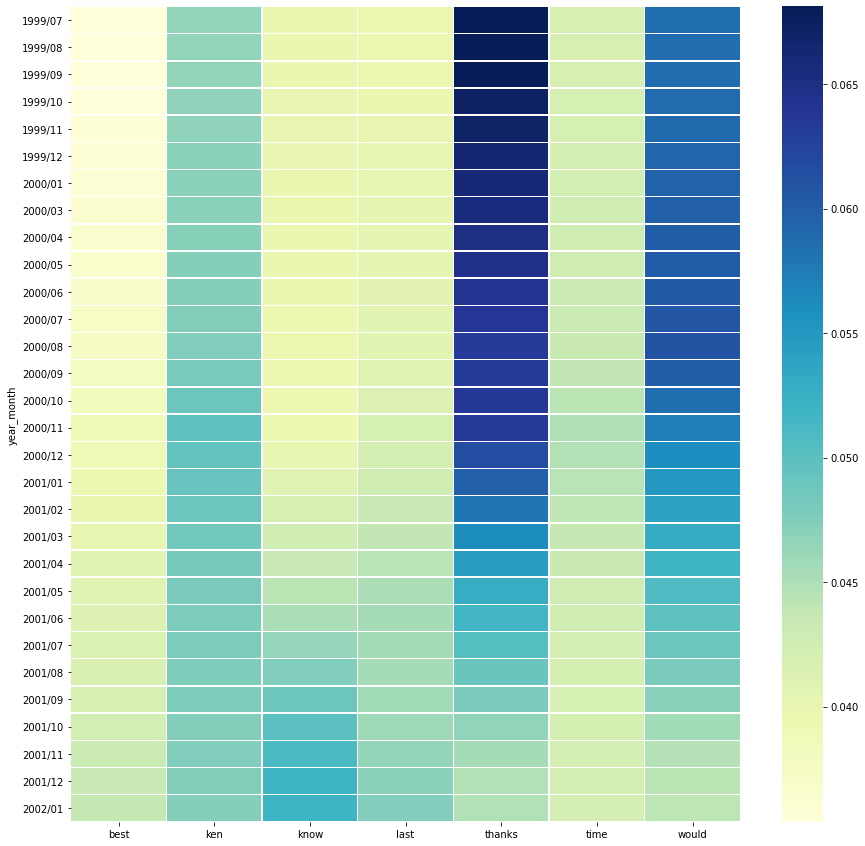

In [58]:
plt.figure(figsize=(15,15))
sns.heatmap(all_unique_word_prob[4],linewidths=.5,cmap="YlGnBu");

For the last topic, we could observe a decrease in using the word "thanks" and "would" but an increasing trend for the word "know" and "last"

I think this increasing trend could be related to the bankruptcy of Enron. However, it is strange that the world "thanks" and "would" is decreasing. It might indicate that the emails contain this topic are less polite than before and it also shows that running an additional sentiment analysis for the document contains this topic could be a good idea to identify the change.

Similar to the LDA model, I have made an interactive widget that utilizes the pyLDAvis library to visualize the change of topic over time.

Contrary to the pattern in the LDA model, the topics generated by sequential LDA seem to be separated and there is only a little overlap between topics.

In [60]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(time=(0,len(cf_df["year_month"].unique())-1))
def visualize_ldaseq(time):
  prepared = ldaseq.dtm_vis(time=time,corpus=tf_corpus)
  return pyLDAvis.prepare(prepared[1],prepared[0],prepared[2],prepared[4],prepared[3])


interactive(children=(IntSlider(value=14, description='time', max=29), Output()), _dom_classes=('widget-intera…

## Conclusion and Complementary sources of data

In this assignment, we have started a simple investigation into the emails of Enron and we indeed found some anomaly behaviour from the proposed model. However, in order to successfully detect the fraud, a deeper investigation is still needed.

Besides the email dataset, there are many other sources of data that could be helpful for detecting fraud. For example, as most of the frauds are related to the stock price, we can analyze the stock records of Enron and see if there is a common pattern with the email data, which could be a good indication of fraud. Moreover, the data from the competitive and CooperatIve company should also be helpful to detect the potential fraud inside Enron.